This notebook is designed to demonstrate the concepts of Model Performance Measures and Model Tuning, as part of the content presented to Great Learning.

In this notebook, I will primarily focus on exploring various performance metrics and techniques for fine-tuning machine learning models to enhance their predictive accuracy.

The dataset and initial code snippets are adapted from a [Kaggle notebook](https://www.kaggle.com/code/ammanrizwan/bank-customer-churn-prediction-notebook/notebook).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import recall_score, make_scorer, f1_score, roc_auc_score
from sklearn.exceptions import ConvergenceWarning
from scipy.stats import loguniform

import warnings
import time

In [2]:
# Suppress convergence warning for LogisticRegression
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
# Dataset directory
df_dir = "Churn_Modelling.csv"

In [4]:
# Load the dataset
df = pd.read_csv(df_dir)
# quick view
print("Training data shape:", df.shape)

Training data shape: (10000, 14)


In [5]:
# Explore dataset
print("Dataset Info:")
print(df.info())
print("--" * 20)
print("First Few Rows:")
df.head()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None
----------------------------------------
First Few Rows:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [7]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['Geography']]).toarray()
        column_names = ['France', 'Germany', 'Spain']
        
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        
        return X

class FeatureLabel(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        label_encoder = LabelEncoder()
        X['Gender'] = label_encoder.fit_transform(X['Gender'])
        return X
    
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(['RowNumber', 'CustomerId', 'Surname', 'Geography'], axis=1, errors='ignore')

pipeline = Pipeline([
    ('feature_encoder', FeatureEncoder()),
    ('feature_label', FeatureLabel()),
    ('feature_dropper', FeatureDropper()),
])

In [8]:
train_data = pipeline.fit_transform(df)
train_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0


In [9]:
# Model fit and predict

# Create features and label
X = train_data.drop("Exited", axis=1)
y = train_data['Exited']

# Spliting the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
# Predicting on the test set
y_pred = model.predict(X_test)

In [10]:
# Model fit and predict (without balancing weight)

model_ub = LogisticRegression()
model_ub.fit(X_train, y_train)
# Predicting on the test set
y_pred_ub = model_ub.predict(X_test)

In [11]:
def roc_auc(y_test, X_test, model):
    """function to calculate auc score and plot roc"""
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = np.round(auc(fpr, tpr), 4)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    return roc_auc

## Model Performance Measures

Model Performance without balanced weight

In [12]:
# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ub))
print("\nClassification Report:\n", classification_report(y_test, y_pred_ub))

Confusion Matrix:
 [[1564   40]
 [ 376   20]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.98      0.88      1604
           1       0.33      0.05      0.09       396

    accuracy                           0.79      2000
   macro avg       0.57      0.51      0.49      2000
weighted avg       0.71      0.79      0.73      2000



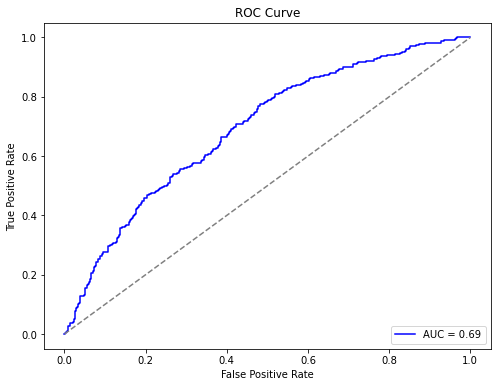

AUC Score:  0.6925


In [13]:
# ROC Curve and AUC
auc_score = roc_auc(y_test, X_test, model_ub)
print("AUC Score: ", auc_score)

Model Performance with balanced weight

In [14]:
# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[1062  542]
 [ 132  264]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.66      0.76      1604
           1       0.33      0.67      0.44       396

    accuracy                           0.66      2000
   macro avg       0.61      0.66      0.60      2000
weighted avg       0.78      0.66      0.70      2000



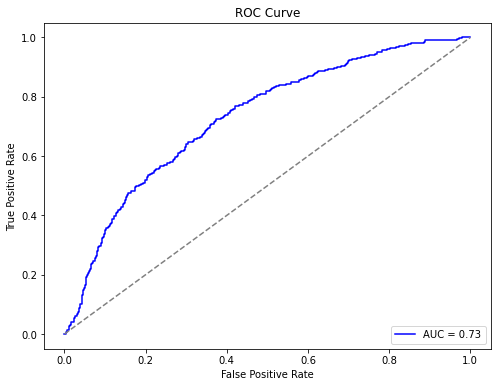

AUC Score:  0.7291


In [15]:
# ROC Curve and AUC
auc_score = roc_auc(y_test, X_test, model)
print("AUC Score: ", auc_score)

## Model Tuning (Hyperparameter Tuning):

### Cross-Validation (Stratified K-Fold Cross-Validation）

In [16]:
# Initialize StratifiedKFold (e.g., 5 splits)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize Logistic Regression
model = LogisticRegression(class_weight='balanced')

# Cross-validation loop
recall_pos_scores = []  # List to store recall for positive class for each fold
f1_marcro_scores = []
f1_neg_scores = []
f1_pos_scores = []
auc_scores = []

classification_reports = []

for train_index, test_index in stratified_kfold.split(X, y):

    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Get classification report for this fold
    report = classification_report(y_test, y_pred, output_dict=True)
    classification_reports.append(report)
    
    # Extract and append scores
    recall_pos_scores.append(report['1']['recall'])
    f1_marcro_scores.append(report['macro avg']['f1-score'])
    f1_neg_scores.append(report['0']['f1-score'])
    f1_pos_scores.append(report['1']['f1-score'])
    auc_scores.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
    
recall_pos_mean = np.round(np.mean(recall_pos_scores),4)
f1_marcro_mean = np.round(np.mean(f1_marcro_scores),4)
f1_neg_mean = np.round(np.mean(f1_neg_scores),4)
f1_pos_mean = np.round(np.mean(f1_pos_scores),4)
auc_mean = np.round(np.mean(auc_scores),4)
    
# Print the overall results
print("\nRecall for positive class: ", recall_pos_mean)
print("\nf1-score macro avg: ", f1_marcro_mean)
print("\nf1-score pos: ", f1_pos_mean)
print("\nf1-score neg: ", f1_neg_mean)
print("\nAUC: ", auc_mean)


Recall for positive class:  0.6691

f1-score macro avg:  0.5961

f1-score pos:  0.4415

f1-score neg:  0.7507

AUC:  0.7116


In [17]:
print(auc_scores)

[0.7207129396984926, 0.6852784141294709, 0.7068162152907915, 0.7177069210967516, 0.7274053714731681]


### Grid Search

Best Parameters: {'C': 100, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation Score: 0.6287986156172768

Time taken: 109.2448 seconds


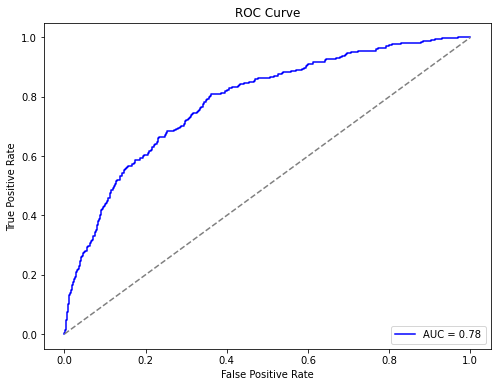


AUC Score:  0.7836

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.73      0.80      1593
           1       0.39      0.69      0.50       407

    accuracy                           0.72      2000
   macro avg       0.65      0.71      0.65      2000
weighted avg       0.80      0.72      0.74      2000



In [18]:
# Define a parameter grid for tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength, the smaller, the stronger
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga'],  # Solvers to try
    'max_iter': [100, 200, 300, 400, 500]  # Maximum iterations for solver, may need to increase this if the solver is not converging, especially for large datasets.
}

# score that combine AUC and F1 for positive class
def auc_f1_scorer(y_true, y_pred_prob):
    
    auc = roc_auc_score(y_true, y_pred_prob)
    y_pred = (y_pred_prob >= 0.5).astype(int)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    combined_score = np.mean([auc, f1])
    
    return combined_score

# Create a custom scorer using make_scorer
custom_scorer = make_scorer(auc_f1_scorer, needs_proba=True)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=LogisticRegression(class_weight='balanced'), 
    param_grid=param_grid, 
    cv=stratified_kfold, 
    scoring=custom_scorer)

start_time = time.time()

# Fit GridSearchCV on training data
grid_search.fit(X_train, y_train)

end_time = time.time()

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Retraining the model with the best parameters
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Evaluate the tuned model
elapsed_time = end_time - start_time
print(f"\nTime taken: {elapsed_time:.4f} seconds")
print("\nAUC Score: ",roc_auc(y_test, X_test, best_model))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

### Random Search

Best Parameters: {'C': 0.02163104373096547, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Score: 0.6101362384073967

Time taken: 13.4770 seconds


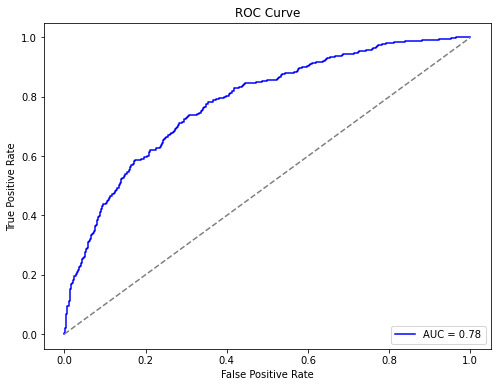


AUC Score:  0.781

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.71      0.80      1593
           1       0.39      0.71      0.50       407

    accuracy                           0.71      2000
   macro avg       0.65      0.71      0.65      2000
weighted avg       0.80      0.71      0.74      2000



In [19]:
start_time = time.time()

# Define a parameter grid for tuning
param_distributions = {
    'C': loguniform(0.001, 100),  # Uniform distribution for regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga'],  # Solvers to try
    'max_iter': [100, 200, 300, 400, 500]  # Maximum iterations for solver, may need to increase this if the solver is not converging, especially for large datasets.
}


# Initialize GridSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=LogisticRegression(class_weight='balanced'), 
    param_distributions=param_distributions,
    cv=stratified_kfold, 
    scoring=custom_scorer)

start_time = time.time()

# Fit GridSearchCV on training data
random_search.fit(X_train, y_train)

end_time = time.time()

# Print the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

# Retraining the model with the best parameters
best_model = random_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Evaluate the tuned model
elapsed_time = end_time - start_time
print(f"\nTime taken: {elapsed_time:.4f} seconds")
print("\nAUC Score: ",roc_auc(y_test, X_test, best_model))
print("\nClassification Report:\n", classification_report(y_test, y_pred))